## Load data

In [1]:
import re
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.utils import np_utils
def extract_urls_from_data_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read()

    urls = re.findall(r'GET (.*?) HTTP/1\.\d', data)

    return urls

train_data_file_path = '/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_normalTraffic_train.txt'
train_urls = extract_urls_from_data_file(train_data_file_path)
train_urls = train_urls + extract_urls_from_data_file('/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_anomalousTraffic_test.txt')
train_label = [0]*len(extract_urls_from_data_file(train_data_file_path)) + [1]*len(extract_urls_from_data_file('/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_anomalousTraffic_test.txt'))
train_label = np.array(train_label)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocess data

In [2]:
import urllib.parse
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.utils import np_utils
from keras.utils import pad_sequences

def decode_and_split_http_request(http_request):
    decoded_request = urllib.parse.unquote(http_request)

    special_characters = ['/', '&', '+', '?', '=', '@', ':']
    split_request = []
    current_token = ''

    for char in decoded_request:
        if char in special_characters:
            if current_token:
                split_request.append(current_token)
                current_token = ''
        else:
            current_token += char

    if current_token:
        split_request.append(current_token)

    return split_request
import time
start_time=time.time()
preprocessed_requests = [decode_and_split_http_request(http_request) for http_request in train_urls]

preprocessed_requests, X_test, train_label, y_test = train_test_split(preprocessed_requests, train_label, test_size=0.25, random_state=42)

# Train Word2Vec model
model = Word2Vec(sentences=preprocessed_requests + X_test, sg=1, vector_size=128, window=5, min_count=1)
# Get word vectors
word_vectors = model.wv

# Create feature matrix
features = [[word_vectors[word] for word in request] for request in preprocessed_requests]

# Determine the maximum sequence length
max_sequence_length = max(len(request) for request in features)
# Pad sequences to have the same length
padded_features = pad_sequences(features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)

# Convert target labels to categorical format
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(train_label)
target_one_hot = np_utils.to_categorical(target_encoded)
time_preprocess=time.time()-start_time
# Split data into training and testing sets
X_train, y_train = padded_features, target_one_hot

In [3]:
max_sequence_length

52

## Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 52, 128)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 50, 128)      49280       ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 49, 128)      65664       ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 128)      82048       ['input_1[0][0]']                
                                                                                              

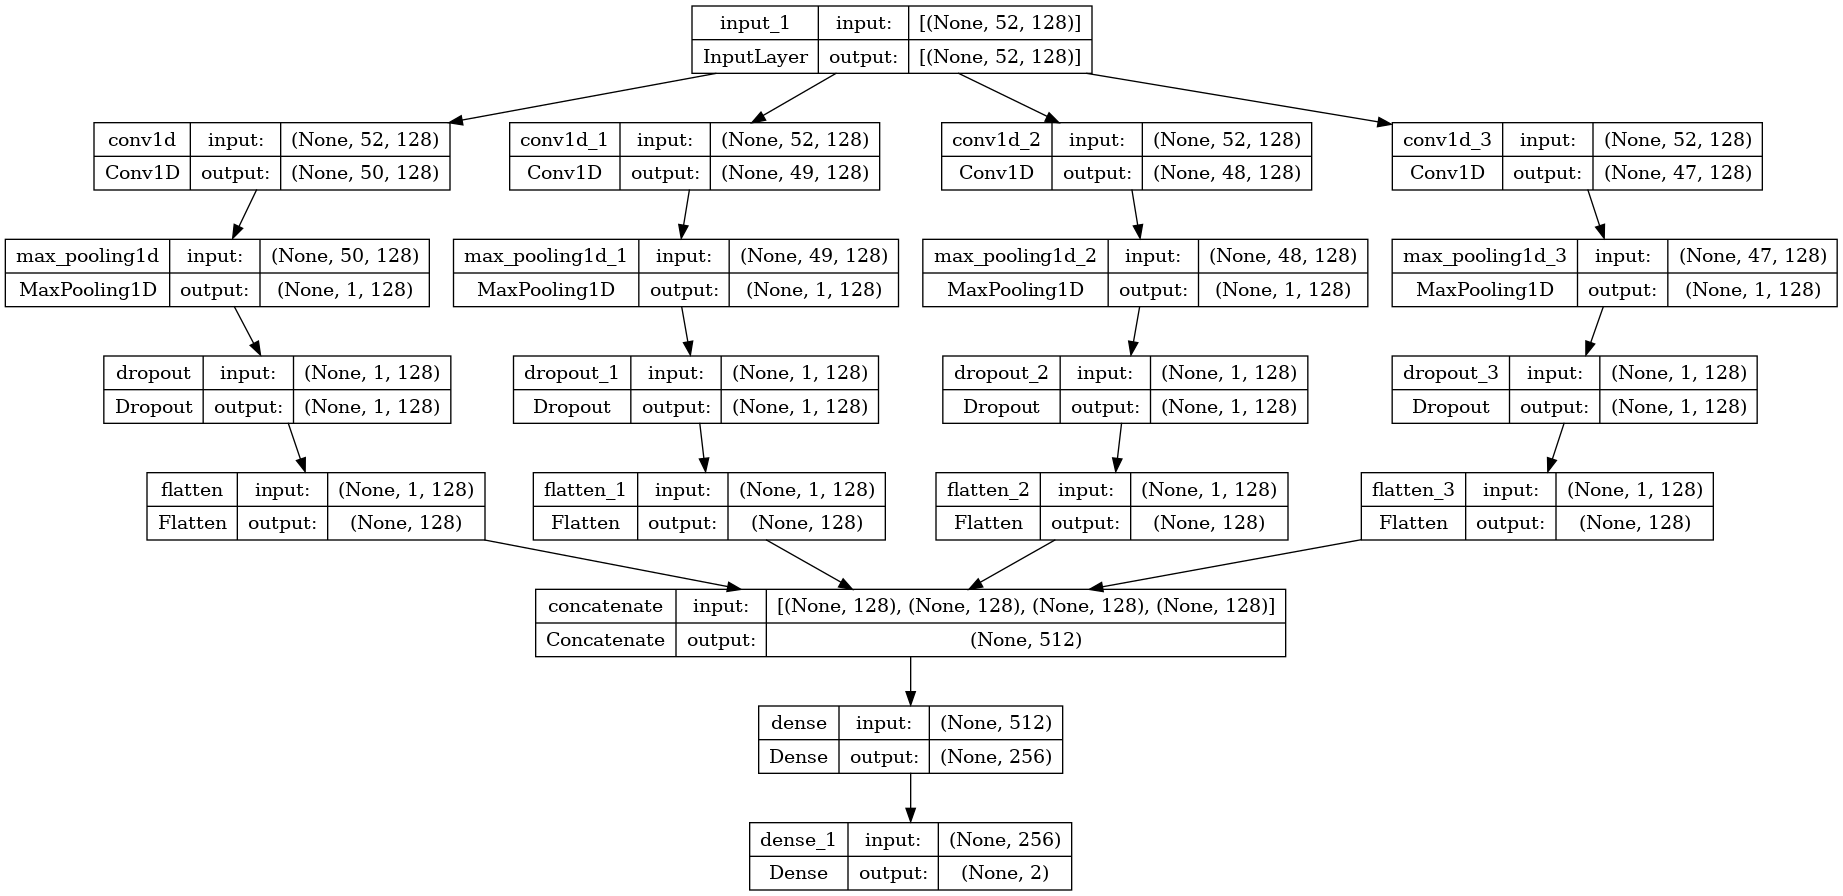

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
start_time=time.time()
# Parameters
l = 52  # Length of the word sequence
k = 128  # Dimension of the embedding vector
n_filters = 128  # Number of filters in the convolution layer
filter_sizes = [3, 4, 5, 6]  # Filter sizes
m = 256  # Number of neurons in the fully-connected layer

# Create an input layer
input_layer = Input(shape=(l, k))

# Create four parallel paths
outputs = []
for filter_size in filter_sizes:
    conv_layer = Conv1D(filters=n_filters, kernel_size=filter_size, activation='relu')(input_layer)
    max_pool = MaxPooling1D(pool_size=l - filter_size + 1)(conv_layer)
    
    # Add dropout with rate 0.5 after max-pooling
    max_pool = Dropout(0.5)(max_pool)
    
    outputs.append(Flatten()(max_pool))


# Concatenate the outputs from the four paths
concatenated = Concatenate()(outputs)

# Fully-Connected Layer
fully_connected = Dense(m, activation='relu')(concatenated)

# Softmax Output Layer
output = Dense(2, activation='softmax')(fully_connected)

# Create the model
model = Model(inputs=input_layer, outputs=output)

# Compile the model with cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True)

## Train model

In [5]:
start_time=time.time()
history = model.fit(X_train, y_train, validation_split=5/75, epochs=10, batch_size=64)
print("Thời gian chạy: ",time.time()-start_time+time_preprocess)

Epoch 1/10
472/472 [==============================] - 14s 8ms/step - loss: 0.2621 - accuracy: 0.8761 - val_loss: 0.1325 - val_accuracy: 0.9332
Epoch 2/10
472/472 [==============================] - 3s 6ms/step - loss: 0.1335 - accuracy: 0.9437 - val_loss: 0.1133 - val_accuracy: 0.9573
Epoch 3/10
472/472 [==============================] - 3s 6ms/step - loss: 0.1101 - accuracy: 0.9567 - val_loss: 0.0822 - val_accuracy: 0.9564
Epoch 4/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0977 - accuracy: 0.9631 - val_loss: 0.0734 - val_accuracy: 0.9782
Epoch 5/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0961 - accuracy: 0.9634 - val_loss: 0.0875 - val_accuracy: 0.9684
Epoch 6/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0899 - accuracy: 0.9667 - val_loss: 0.0833 - val_accuracy: 0.9740
Epoch 7/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0896 - accuracy: 0.9675 - val_loss: 0.0892 - val_accuracy: 0.9568
Epoch

## Evaluate

In [6]:
import time

start_time = time.time()
preprocessed_requests = [decode_and_split_http_request(http_request) for http_request in train_urls]
# Create feature matrix
features = [[word_vectors[word] for word in request] for request in X_test]
# Determine the maximum sequence length
# max_sequence_length = max(len(request) for request in features)
# Pad sequences to have the same length
padded_features = pad_sequences(features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)

# Convert target labels to categorical format
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(y_test)
target_one_hot = np_utils.to_categorical(target_encoded)

# Split data into training and testing sets
X_test, y_test = padded_features, target_one_hot
y_prob = model.predict(X_test)
print("Thời gian chạy là: --- %s giây ---" % (time.time() - start_time))

337/337 [==============================] - 1s 2ms/step
Thời gian chạy là: --- 4.189462900161743 giây ---


In [7]:
y_test = np.argmax(y_test, axis=1)

In [8]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
import sklearn.metrics as metrics
import pandas as pd
clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

337/337 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0     0.9631    0.9956    0.9791      7009
           1     0.9912    0.9290    0.9591      3763

    accuracy                         0.9723     10772
   macro avg     0.9772    0.9623    0.9691     10772
weighted avg     0.9730    0.9723    0.9721     10772

[[6978   31]
 [ 267 3496]]
      TPR       FPR       FNR   ROC AUC
   0.9290    0.0044    0.0710    0.9944
